#Libraries

In [0]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Data

Since the Government fails to provide a complete and open dataset for disease status in the country, several young doctors in Myanmar volunteered on their own to monitor announcements. Current data applied is collected by Dr. Nyein Chan Ko Ko.

In [0]:
# please update the dictionary for future cases
# in cummulative form
Myanmar = {"3/21/20" : 1,
           "3/22/20" : 1,
           "3/23/20" : 3,
           "3/24/20" : 3,
           "3/25/20" : 5,
           "3/26/20" : 8,
           "3/27/20" : 8,
           "3/28/20" : 8,
           "3/29/20" : 10}

In [3]:
confirmed_df = pd.DataFrame(list(Myanmar.items()),columns = ["Date","Case"]) 
confirmed_df["Date"] = pd.to_datetime(confirmed_df["Date"])
confirmed_df["ndays"] = np.arange(len(confirmed_df))

# Natural Log of Real Cases
confirmed_df["logCase"] = np.log(confirmed_df.Case).astype(float)

print(confirmed_df)

        Date  Case  ndays   logCase
0 2020-03-21     1      0  0.000000
1 2020-03-22     1      1  0.000000
2 2020-03-23     3      2  1.098612
3 2020-03-24     3      3  1.098612
4 2020-03-25     5      4  1.609438
5 2020-03-26     8      5  2.079442
6 2020-03-27     8      6  2.079442
7 2020-03-28     8      7  2.079442
8 2020-03-29    10      8  2.302585


Natural log makes it better in terms of visualization and long term comparison, make the data look more linear. That is why I will be plotting both real and natural log line graphs.

# Model of choice

True exponential does not exist, but exponential growth is assumed until the inflection point has arrived. Linear Regression is applied.

## Logistic Regression
### Ordinary Least Squared Regression

In [4]:
X = confirmed_df.ndays
X = sm.add_constant(X)
y = confirmed_df.logCase
model = sm.OLS(y, X)
result = model.fit()
result.summary()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                logCase   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     56.31
Date:                Sun, 29 Mar 2020   Prob (F-statistic):           0.000137
Time:                        18:20:53   Log-Likelihood:                -1.2830
No. Observations:                   9   AIC:                             6.566
Df Residuals:                       7   BIC:                             6.960
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1459      0.194      0.750      0.478      -0.314       0.606
ndays          0.3065      0.041      7.504      0.000       0.210       0.403
==============================================================================
Omnibus:                        1.001   Durbin-Watson:                   1.539
Prob(Omnibus):                  0.606   Jarque-Bera (JB):                0.611
Skew:                          -0.067   Prob(JB):                        0.737
Kurtosis:                       1.730   Cond. No.                         9.06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Exponential Formaula<br> y = ab<sup>x</sup> <br>
a = Initial Value<br>
b = Rate of Change<br>
x = The feature ( Here it is time )<br>

b = (1+r) = Growth Rate <- Before Inflection <br>
b = (1-r) = Decay Rate <- After Inflection <br>

In the summary, "constant stands" for initial "a".<br>
"ndays" is the coefficient of "time", which means the value increasing y as x is increased by 1. In our case, the number of cases to increase as the next day comes.

In [0]:
def linear_predictions(t):
    return np.exp(result.params["const"]) * np.exp(result.params["ndays"]) ** t

As we fitted our model with natural log values, we should change them back to real numbers to predict.

# Next Week Prediction

In [6]:
ndays = len(confirmed_df)+3
nextweek_df = pd.DataFrame(columns=["ndays","Date"])
nextweek_df["ndays"] = np.arange(ndays)
nextweek_df.loc[0,"Date"]=confirmed_df.loc[0,"Date"]
for i in range(1,len(nextweek_df)):
    nextweek_df.loc[i,"Date"] = nextweek_df.loc[i-1,"Date"] + pd.Timedelta(days=1)
    i=i+1
nextweek_df["Predictions"] = nextweek_df.ndays.apply(linear_predictions)

# Natural Log of Predicted Cases
nextweek_df["logPredictions"] = np.log(nextweek_df.Predictions).astype(float)

print(nextweek_df)

    ndays                 Date  Predictions  logPredictions
0       0  2020-03-21 00:00:00     1.157052        0.145876
1       1  2020-03-22 00:00:00     1.572073        0.452395
2       2  2020-03-23 00:00:00     2.135955        0.758914
3       3  2020-03-24 00:00:00     2.902096        1.065433
4       4  2020-03-25 00:00:00     3.943042        1.371952
5       5  2020-03-26 00:00:00     5.357362        1.678472
6       6  2020-03-27 00:00:00     7.278981        1.984991
7       7  2020-03-28 00:00:00     9.889861        2.291510
8       8  2020-03-29 00:00:00    13.437231        2.598029
9       9  2020-03-30 00:00:00    18.256999        2.904549
10     10  2020-03-31 00:00:00    24.805558        3.211068
11     11  2020-04-01 00:00:00    33.703003        3.517587


Although I stated next week, here I added only "3". Since our data and history is very short right now, it is not sufficient to predict far without sacraficing. This currently here is a proof of concept. We shall increase the data and after that, we should pursure further analysis.

# Real Number Plot

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


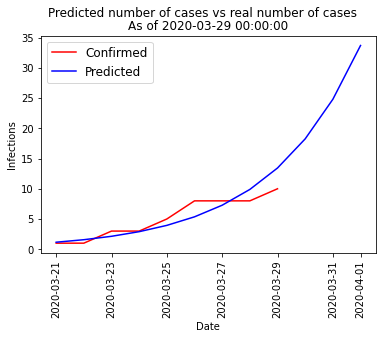

In [7]:
confirmed_x = pd.date_range(start=confirmed_df["Date"][confirmed_df.index[0]], end=confirmed_df["Date"][confirmed_df.index[-1]])
confirmed_y = confirmed_df["Case"].tolist()
confirmed_plot = pd.Series(data=confirmed_y, index=confirmed_x)

nextweek_x = pd.date_range(start=nextweek_df["Date"][nextweek_df.index[0]], end=nextweek_df["Date"][nextweek_df.index[-1]])
nextweek_y = nextweek_df["Predictions"].tolist()
nextweek_plot = pd.Series(data=nextweek_y, index=nextweek_x)

fig, ax = plt.subplots()
ax.plot(confirmed_plot, label="Confirmed", color="red")
ax.plot(nextweek_plot, label="Predicted", color ="blue")
legend = ax.legend(loc="upper left", fontsize="large")
plt.xlabel("Date")
plt.ylabel("Infections")
plt.suptitle("Predicted number of cases vs real number of cases")
plt.title("As of "+str(confirmed_df["Date"][confirmed_df.index[-1]]))
plt.xticks(rotation=90)
plt.show()

# Natural Log Plot

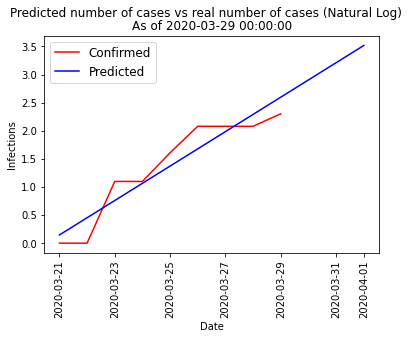

In [8]:
confirmed_logy = confirmed_df["logCase"].tolist()
confirmed_logplot = pd.Series(data=confirmed_logy, index=confirmed_x)

nextweek_logy = nextweek_df["logPredictions"].tolist()
nextweek_logplot = pd.Series(data=nextweek_logy, index=nextweek_x)

fig, ax = plt.subplots()
ax.plot(confirmed_logplot, label="Confirmed", color="red")
ax.plot(nextweek_logplot, label="Predicted", color ="blue")
legend = ax.legend(loc="upper left", fontsize="large")
plt.xlabel("Date")
plt.ylabel("Infections")
plt.suptitle("Predicted number of cases vs real number of cases (Natural Log)")
plt.title("As of "+str(confirmed_df["Date"][confirmed_df.index[-1]]))
plt.xticks(rotation=90)
plt.show()